# Feedback Loops in Adaptive Learning Systems

In [12]:
%matplotlib  inline
from collections import OrderedDict
from math import sqrt, log
from random import random, randint, choice
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [140]:
class ProxyStudent:
    def __init__(self, p_learn, p_good, init_skill=0.1):
        """
        Args:
            p_learn = prabability of getting learned after 1 question
            p_good = [probability of good performance for skill=0, -||- skill=1]
        """
        self.p_learn = p_learn
        self.p_good = p_good
        self.skill = init_skill
        
    def update_skill(self, performance):
        """Called when student answers a question."""
        
        # Performance at skill: p_perf_at_skill[performance][skill]
        p_perf_at_skill = [list(map(lambda x: 1 - x, self.p_good)), self.p_good]
        
        likelihood_good = self.skill * p_perf_at_skill[performance][1]
        likelihood_bad = (1 - self.skill) * p_perf_at_skill[performance][0]
        
        # New skill according to Bayes theorem
        self.skill = (likelihood_good / (likelihood_good + likelihood_bad))
        
        # Learning
        self.skill += (1 - self.skill) * self.p_learn
        
s = ProxyStudent(p_learn=0.1, p_good=[0.2, 0.7])
for i in range(10): 
    answer = int(randint(0, 5) > 3)
    s.update_skill(answer)
    print(str(answer) + ' : ' + str(s.skill))

0 : 0.136
1 : 0.4197014925373134
1 : 0.745142024763292
0 : 0.5706942030467234
0 : 0.3994006937077608
1 : 0.7295276924737711
0 : 0.5525646026068052
0 : 0.3848718748194689
1 : 0.7178569749159035
0 : 0.539433011917351


In [141]:
class TrueStudent:
    def __init__(self, p_learn, p_good, max_answers=20):
        """
        Args:
            p_learn = prabability of getting learned after 1 question
            p_good = [probability of good performance for skill=0, -||- skill=1]
        """
        self.p_learn = p_learn
        self.p_good = p_good
        self.skill = 0
        self.n_answers = 0
        self.max_answers = max_answers
        
    def update_skill(self):
        """Called when student answers a question."""
        if self.skill == 1:
            return
        if random() < self.p_learn:
            self.skill = 1
            
    def answer(self):
        """Return a performance for a new question"""
        self.n_answers += 1
        self.update_skill()
        p_good = self.p_good[self.skill]
        performance = int(random() < p_good)
        return performance

    def leave(self, mastery_decision):
        return mastery_decision or self.n_answers >= self.max_answers
    
s = TrueStudent(p_learn=1.0, p_good=(0.0, 1.))
for i in range(10): 
    answer = s.answer()
    print(str(answer) + ' : ' + str(s.skill))

1 : 1
1 : 1
1 : 1
1 : 1
1 : 1
1 : 1
1 : 1
1 : 1
1 : 1
1 : 1


In [264]:
def proxy_objective_solved_tasks(histories):
    """
    Args:
        histories: history of each student
    """
    return sum([len(history) for history in histories])

def proxy_objective_successful_tasks(histories):
    return sum([sum(history) for history in histories])

class LearningSystem:
    def __init__(self, threshold, proxy_objective, threshold_delta=0.05):
        self.threshold = threshold
        self.objectives = None
        self.proxy_objective = proxy_objective
        self.threshold_delta = threshold_delta
        
    def do_iteration(self, true_students):
        """
        Performs the simulation for a single month.
        Will affect local attributes. (threshold)
        """
        thresholds = [self.threshold - self.threshold_delta,
                      self.threshold + self.threshold_delta]
        groups = [true_students[:len(true_students) // 2],
                  true_students[len(true_students) // 2:]]
        
        objectives = []
        for group, t in zip(groups, thresholds):
            histories = [self.process_student(s, t) for s in group]
            objectives.append(self.proxy_objective(histories))
        
        if objectives[1] >= objectives[0]:
            self.threshold = min(1 - self.threshold_delta, self.threshold + self.threshold_delta)
        else:
            self.threshold = max(self.threshold_delta, self.threshold - self.threshold_delta)
        self.objectives = objectives #max(objectives)
    
    def process_student(self, true_student, threshold=None):
        threshold = threshold if threshold is not None else self.threshold
        # Intentional, TODO: think about it again.
        proxy_student = ProxyStudent(true_student.p_learn, true_student.p_good)
        mastery = False
        history = []
        
        while not true_student.leave(mastery):
            performance = true_student.answer()
            proxy_student.update_skill(performance)
            mastery = proxy_student.skill >= threshold
            
            history.append(performance)
        
        return history

In [265]:
def simulate_single_student(
        proxy_objective=proxy_objective_solved_tasks,
        p_learn=0.1,
        p_good=[0.2, 0.7],
        threshold=0.95):
    als = LearningSystem(threshold=threshold, proxy_objective=proxy_objective)
    true_student = TrueStudent(p_learn=p_learn, p_good=p_good)
    history = als.process_student(true_student)
    print(len(history), history)
    
simulate_single_student()

5 [0, 1, 1, 1, 1]


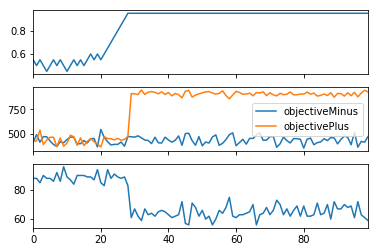

In [292]:
def perform_simulation(
        proxy_objective=proxy_objective_solved_tasks,
        p_learn=0.1,
        p_good=[0.01, 0.7],
        n_iters=100,
        n_students=100):
    als = LearningSystem(threshold=0.5, proxy_objective=proxy_objective)
    thresholds = []
    objectivePlus, objectiveMinus = [], []
    mastery = []
    for i_iter in range(n_iters):
        true_students = create_students(n_students, p_learn, p_good)
        als.do_iteration(true_students)
        thresholds.append(als.threshold)
        mastery.append(sum(int(s.n_answers < s.max_answers) for s in true_students))
        objectiveMinus.append(als.objectives[0])
        objectivePlus.append(als.objectives[1])
    results = pd.DataFrame({
        'thresholds': thresholds,
        'mastery': mastery,
        'objectiveMinus': objectiveMinus,
        'objectivePlus': objectivePlus})
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True)
    results.thresholds.plot(ax=ax1)
    results[['objectiveMinus', 'objectivePlus']].plot(ax=ax2)
    results.mastery.plot(ax=ax3)

def create_students(n_students, p_learn, p_good):
    return [
        TrueStudent(p_learn=p_learn, p_good=p_good)
        for _ in range(n_students)
    ]
    
perform_simulation()

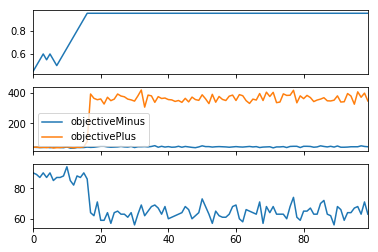

In [297]:
perform_simulation(proxy_objective=proxy_objective_successful_tasks)